In [33]:
import sys
import os

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import torch

# import some common libraries
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

def cv2_imshow( im ):
    cv2.imshow('',im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

things = MetadataCatalog.get("coco_2017_train").thing_classes
print(things)
from actorlogger import ActorLogger, Frame
import re
from PIL import Image

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [19]:
##### CAMERA CALIBRATION CONFIG - this configuration comes from how we set up Cameras in CARLA
baseline_F = 0.8 # 80cm on top car
baseline_LC = np.sqrt([0.2*0.2 *2])[0] # left corner
baseline_RC = np.sqrt([0.2*0.2 *2])[0] # right corner
baseline_L = 0.5 # left side
baseline_R = 0.5 # right side

# rotation matrices

# translation matrices
translate_F = torch.tensor([[1.,0,0,-0.3],[0,1.,0,0.4],[0,0,1.,-1.0],[0,0,0,1.]])


# {"x": z, "y": x, "z": y } Switch between CARLA UE and image coordinate system
swap_axes = torch.tensor([[0,0,1.0,0],[1,0,0,0],[0,1.0,0,0],[0,0,0,1.]])

# camera properties
fov=90
W=1280
H=720

fov = fov / 360. * 2. * np.pi
f = W / (2. * np.tan(fov / 2.))  # focus length

In [20]:
########### CONFIGURE DETECTRON
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

In [5]:
########### CONFIGURE STEREO MATCHER
num_disp = 128
window_size = 11
stereo = cv2.StereoSGBM_create(numDisparities = num_disp, blockSize = window_size )
stereo.setUniquenessRatio(5)

In [37]:
########### CONFIGURE PATH AND JSON LOGGER
path = "/home/najib/Thesis/Rendering/" + str(3)
subpath = path + "/out/"
saveimpath = path + "/det/"
os.makedirs(saveim, exist_ok=True)
actorLogger = ActorLogger(path)

In [42]:
## First frame
sortedPaths = sorted(os.listdir(subpath))
frame_id = int(re.search(r'\d+', sortedPaths[0]).group())
print("First frame: ", frame_id, " last frame: ", re.search(r'\d+', sortedPaths[-1]).group())

while(os.path.exists((subpath + str(frame_id) + 'FL.jpg'))):
    frame = Frame(frame_id)
    print("Processing frame ", frame_id)

    # Read front stereo images
    imgL = cv2.imread(subpath + str(frame_id) + 'FL.jpg')
    imgR = cv2.imread(subpath + str(frame_id) + 'FR.jpg')

    # Hide ego car from image
    imgL[630:H, 410:W] = [0,0,0]
    imgR[630:H, 0:880] = [15,15,15]

    # Calculate disparity with stereo block matching algorithm
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    disparity = stereo.compute(grayL, grayR).astype(np.float32) / 16.0
    # save image
    Image.fromarray(disparity, 'L').save(('%s/%d%s.jpg' % (saveimpath, frame_id, "DP")), 'JPEG', quality=85)

    # Predict detections with detectron2
    outputs = predictor(imgL)

    # Determine actors
    for i in range(0, len(outputs["instances"])):
        
        if(outputs["instances"].pred_classes[i] not in (0,1,2,3,4,5,6,7)):
            continue

        mask = outputs["instances"].pred_masks[i]
        masked = torch.tensor(disparity)[mask]
        nonnegative = masked > 0  # negative values in depth map mean unmatched regions
        mean_disparity = masked[nonnegative].mean()

        [[cx, cy]] = outputs["instances"].pred_boxes[i].get_centers()

        if(torch.isnan(mean_disparity)):
            mean_disparity = torch.tensor(0.1)

        dx = cx - W/2
        dy = cy - H/2
        z = f*baseline_F/mean_disparity
        x = dx*z/f
        y = dy*z/f
        
        pos = torch.tensor([x,y,z,1])

        swaped = torch.mv(swap_axes,pos)
        [x,y,z, _] = torch.mv(translate_F,swaped)
        
        x = float(x)
        y = float(y)
        z = float(z)
        frame.addActor("", things[outputs["instances"].pred_classes[i]], 0, {"x": x, "y": y, "z": z })


    actorLogger.addFrame(frame)  
    frame_id += 1

actorLogger.save()


First frame:  170  last frame:  707
Processing frame  170
Processing frame  171
Processing frame  172
Processing frame  173
Processing frame  174
Processing frame  175


KeyboardInterrupt: 

tensor(298.5090, device='cuda:0') tensor(407.5181, device='cuda:0')


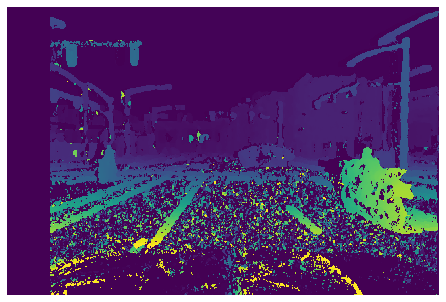

tensor([[0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]])
tensor([1., 2., 3., 1.])
tensor([2.7000, 1.4000, 1.0000, 1.0000])
tensor(1.) tensor(2.) tensor(3.)
bicycle


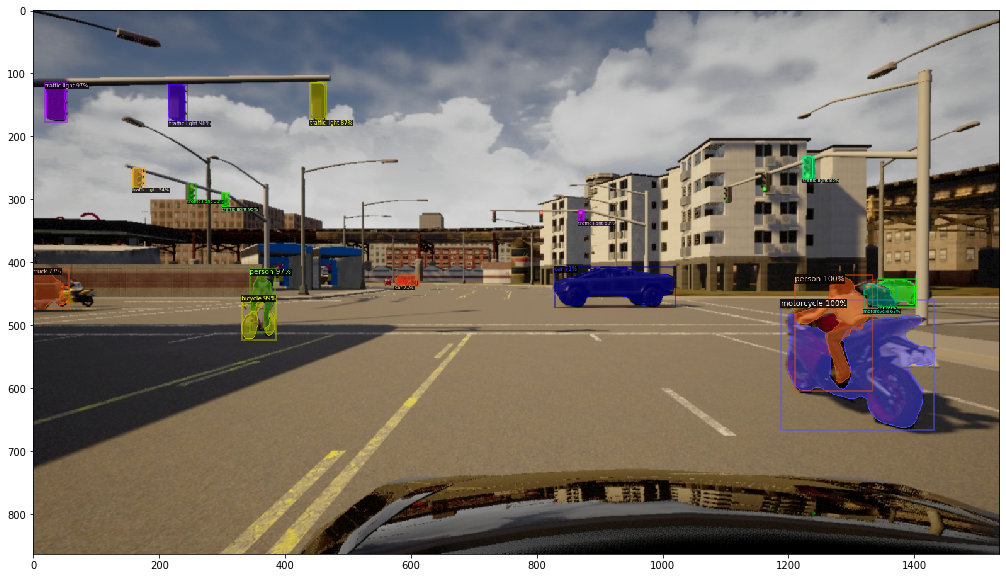

In [55]:
imgL = cv2.imread('/home/najib/Thesis/Rendering/1/out/114FL.jpg')
imgR = cv2.imread('/home/najib/Thesis/Rendering/1/out/114FR.jpg')
outputs = predictor(imgL)
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
# outputs["instances"].pred_boxes[0]

i =2
[[cx, cy]] = outputs["instances"].pred_boxes[i].get_centers()
print(cx, cy)

grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
disp = stereo.compute(grayL, grayR).astype(np.float32) / 16.0
disparity = (disp)

fig = plt.figure(frameon=False)

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

ax.imshow(disparity, aspect='auto')
plt.savefig('foo.png', bbox_inches='tight',transparent=True, pad_inches=0)
plt.show()

mask = outputs["instances"].pred_masks[i]
masked = torch.tensor(disparity)[mask]
nonnegative = masked > 0  # negative values in depth map mean unmatched regions
normdist = masked[nonnegative].mean()

difference = normdist

dx = cx - W/2
dy = cy - H/2
z = torch.tensor(f*baseline_F)/difference
x = dx*z/f
y = dy*z/f


x = torch.tensor(1.0)
y = torch.tensor(2.0)
z = torch.tensor(3.0)

ll = torch.tensor([x,y,z,1])

print(swap_axes)
print(ll)
swaped = torch.mv(swap_axes,ll)
print(torch.mv(translate_F,swaped))
print(x,y,z)
print(things[outputs["instances"].pred_classes[i]])

v = Visualizer(imgL[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
detim = v.get_image()

plt.figure(figsize=(20,10))
plt.imshow(detim)